In [70]:
# take 10% of images from each class to validation

In [71]:
# there are B&W images in data!

In [72]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus // 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Data

In [73]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [74]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [75]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [76]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [77]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data
from xml.dom.expatbuilder import theDOMImplementation


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

print(f'Mean: {mean.cpu()}')
print(f'Std: {std.cpu()}')

train_img_transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    T.Normalize(mean, std)
])

val_img_transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [78]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [79]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [80]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
# X, Y = next(iter(train_dataloader))
# X.shape, Y.shape

---

### Model

In [81]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [82]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(in_shape))

        layers.append(nn.Linear(in_shape, out_shape))

        if activation is not None:
            layers.append(activation)
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [83]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [84]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 32, kernel_size=5)
        self.conv2 = CnnBlock(32, 64, kernel_size=5)
        self.conv3 = CnnBlock(64, 128, kernel_size=3)
        self.conv4 = CnnBlock(128, 64, kernel_size=3)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [85]:
model = BaselineModel()

# out = model(X)
# out.shape

---

### Train

In [86]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [87]:
set_seed(123)

model = BaselineModel()
model.to(DEVICE)

Random seed set as 123


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1

In [88]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 128,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [89]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [90]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [91]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------


[21:25:01] Step 20/704: train loss = 5.58167
[21:25:02] Step 40/704: train loss = 5.50837
[21:25:03] Step 60/704: train loss = 5.44593
[21:25:04] Step 80/704: train loss = 5.39472
[21:25:05] Step 100/704: train loss = 5.34588
[21:25:06] Step 120/704: train loss = 5.3023
[21:25:07] Step 140/704: train loss = 5.25435
[21:25:08] Step 160/704: train loss = 5.20981
[21:25:09] Step 180/704: train loss = 5.17527
[21:25:10] Step 200/704: train loss = 5.15347
[21:25:11] Step 220/704: train loss = 5.12367
[21:25:12] Step 240/704: train loss = 5.09045
[21:25:13] Step 260/704: train loss = 5.05884
[21:25:14] Step 280/704: train loss = 5.02593
[21:25:15] Step 300/704: train loss = 4.99639
[21:25:16] Step 320/704: train loss = 4.97209
[21:25:17] Step 340/704: train loss = 4.94676
[21:25:18] Step 360/704: train loss = 4.92201
[21:25:19] Step 380/704: train loss = 4.89602
[21:25:20] Step 400/704: train loss = 4.87203
[21:25:21] Step 420/704: train loss = 4.84845
[21:25:22] Step 440/704: train loss = 4

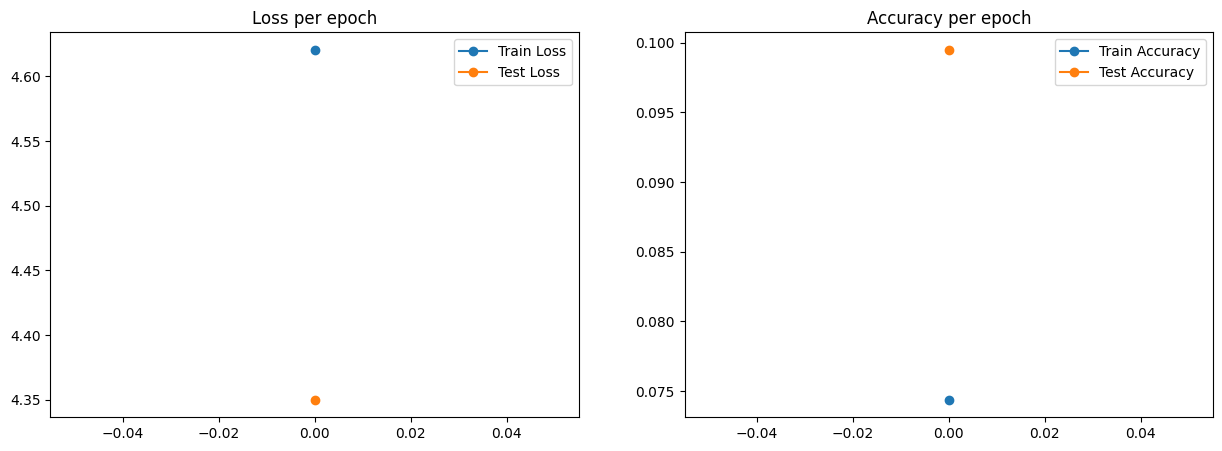

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[21:25:40] Step 20/704: train loss = 4.06097
[21:25:41] Step 40/704: train loss = 4.07858
[21:25:42] Step 60/704: train loss = 4.08686
[21:25:43] Step 80/704: train loss = 4.06156
[21:25:44] Step 100/704: train loss = 4.05974
[21:25:45] Step 120/704: train loss = 4.05395
[21:25:46] Step 140/704: train loss = 4.05452
[21:25:47] Step 160/704: train loss = 4.04164
[21:25:48] Step 180/704: train loss = 4.03303
[21:25:49] Step 200/704: train loss = 4.03146
[21:25:50] Step 220/704: train loss = 4.02854
[21:25:51] Step 240/704: train loss = 4.01811
[21:25:52] Step 260/704: train loss = 4.00926
[21:25:53] Step 280/704: train loss = 4.00108
[21:25:54] Step 300/704: train loss = 4.00015
[21:25:56] Step 320/704: train loss = 3.99536
[21:25:57] Step 340/704: train loss = 3.98781
[21:25:58] Step 360/704: train loss = 3.97915
[21:25:59] Step 380/704: train loss = 3.97197
[21:26:00] Step 400/704: train loss 

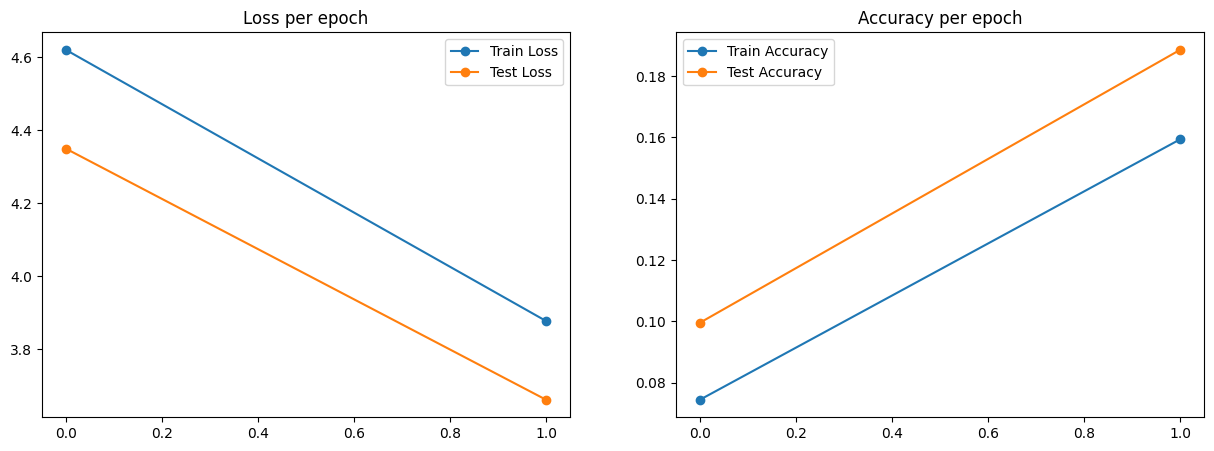

Saving best model

 		 ------------------------------ EPOCH: 3 ------------------------------
[21:26:20] Step 20/704: train loss = 3.6652
[21:26:21] Step 40/704: train loss = 3.58982
[21:26:22] Step 60/704: train loss = 3.59284
[21:26:23] Step 80/704: train loss = 3.56697
[21:26:24] Step 100/704: train loss = 3.56714
[21:26:25] Step 120/704: train loss = 3.57432
[21:26:26] Step 140/704: train loss = 3.58206
[21:26:27] Step 160/704: train loss = 3.56702
[21:26:28] Step 180/704: train loss = 3.56982
[21:26:29] Step 200/704: train loss = 3.57143
[21:26:30] Step 220/704: train loss = 3.57226
[21:26:31] Step 240/704: train loss = 3.57156
[21:26:32] Step 260/704: train loss = 3.56775
[21:26:33] Step 280/704: train loss = 3.57123
[21:26:34] Step 300/704: train loss = 3.5658
[21:26:35] Step 320/704: train loss = 3.56423
[21:26:36] Step 340/704: train loss = 3.56433
[21:26:37] Step 360/704: train loss = 3.56247
[21:26:38] Step 380/704: train loss = 3.56151
[21:26:39] Step 400/704: train loss = 

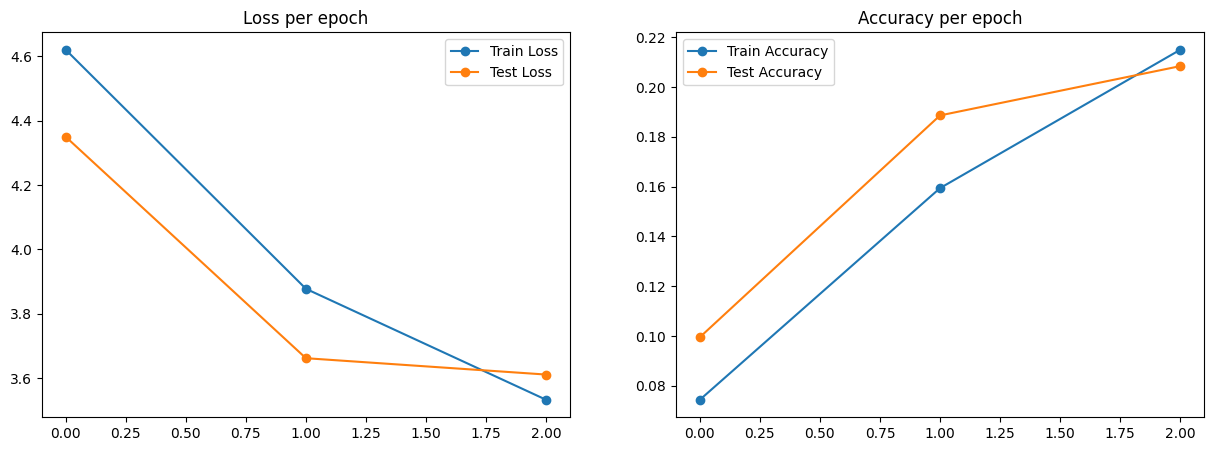

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[21:27:00] Step 20/704: train loss = 3.36994
[21:27:01] Step 40/704: train loss = 3.34401
[21:27:02] Step 60/704: train loss = 3.32242
[21:27:03] Step 80/704: train loss = 3.3212
[21:27:04] Step 100/704: train loss = 3.31728
[21:27:05] Step 120/704: train loss = 3.30639
[21:27:06] Step 140/704: train loss = 3.29977
[21:27:07] Step 160/704: train loss = 3.30167
[21:27:08] Step 180/704: train loss = 3.30386
[21:27:09] Step 200/704: train loss = 3.30698
[21:27:10] Step 220/704: train loss = 3.31209
[21:27:11] Step 240/704: train loss = 3.31205
[21:27:12] Step 260/704: train loss = 3.30608
[21:27:13] Step 280/704: train loss = 3.30602
[21:27:14] Step 300/704: train loss = 3.3054
[21:27:15] Step 320/704: train loss = 3.3056
[21:27:16] Step 340/704: train loss = 3.30561
[21:27:17] Step 360/704: train loss = 3.30426
[21:27:18] Step 380/704: train loss = 3.30506
[21:27:19] Step 400/704: train loss = 3

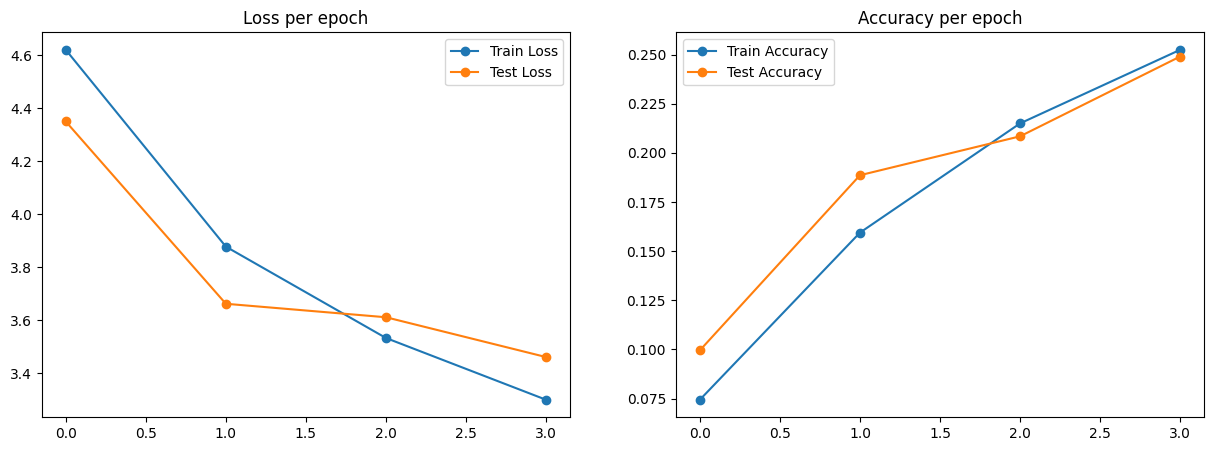

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[21:27:40] Step 20/704: train loss = 3.14055
[21:27:41] Step 40/704: train loss = 3.09688
[21:27:42] Step 60/704: train loss = 3.08485
[21:27:43] Step 80/704: train loss = 3.08075
[21:27:44] Step 100/704: train loss = 3.08748
[21:27:45] Step 120/704: train loss = 3.09859
[21:27:46] Step 140/704: train loss = 3.09985
[21:27:47] Step 160/704: train loss = 3.10335
[21:27:48] Step 180/704: train loss = 3.10781
[21:27:49] Step 200/704: train loss = 3.10529
[21:27:50] Step 220/704: train loss = 3.1029
[21:27:51] Step 240/704: train loss = 3.10229
[21:27:52] Step 260/704: train loss = 3.10652
[21:27:53] Step 280/704: train loss = 3.10506
[21:27:54] Step 300/704: train loss = 3.10825
[21:27:55] Step 320/704: train loss = 3.11058
[21:27:56] Step 340/704: train loss = 3.11055
[21:27:57] Step 360/704: train loss = 3.10868
[21:27:58] Step 380/704: train loss = 3.11012
[21:27:59] Step 400/704: train loss =

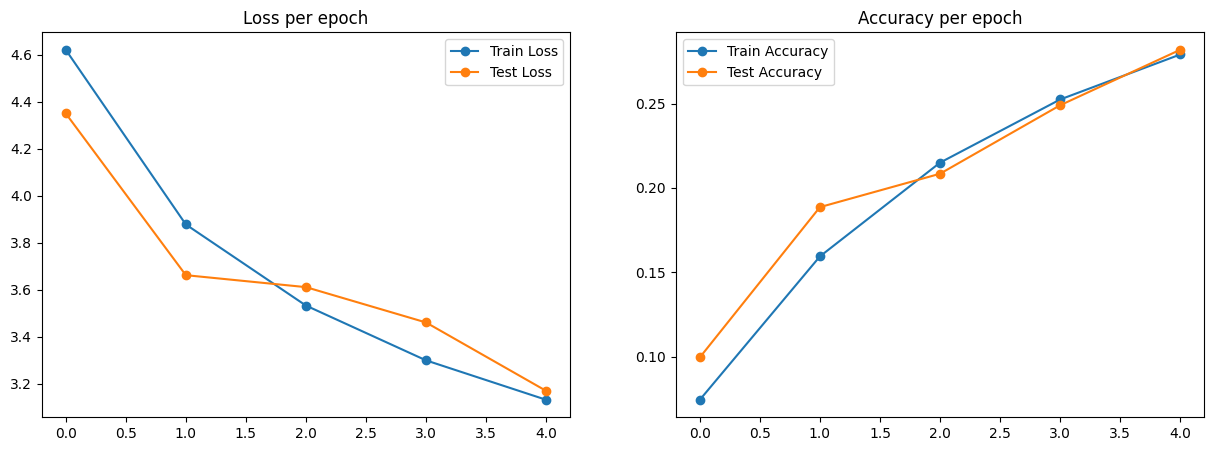

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[21:28:19] Step 20/704: train loss = 2.86329
[21:28:20] Step 40/704: train loss = 3.22941
[21:28:21] Step 60/704: train loss = 3.33002
[21:28:22] Step 80/704: train loss = 3.299
[21:28:23] Step 100/704: train loss = 3.25764
[21:28:24] Step 120/704: train loss = 3.2463
[21:28:25] Step 140/704: train loss = 3.22524
[21:28:26] Step 160/704: train loss = 3.20009
[21:28:27] Step 180/704: train loss = 3.17578
[21:28:28] Step 200/704: train loss = 3.16094
[21:28:29] Step 220/704: train loss = 3.1454
[21:28:30] Step 240/704: train loss = 3.13473
[21:28:31] Step 260/704: train loss = 3.1223
[21:28:32] Step 280/704: train loss = 3.11303
[21:28:33] Step 300/704: train loss = 3.10499
[21:28:34] Step 320/704: train loss = 3.0997
[21:28:35] Step 340/704: train loss = 3.09586
[21:28:36] Step 360/704: train loss = 3.09437
[21:28:37] Step 380/704: train loss = 3.08844
[21:28:38] Step 400/704: train loss = 3.08

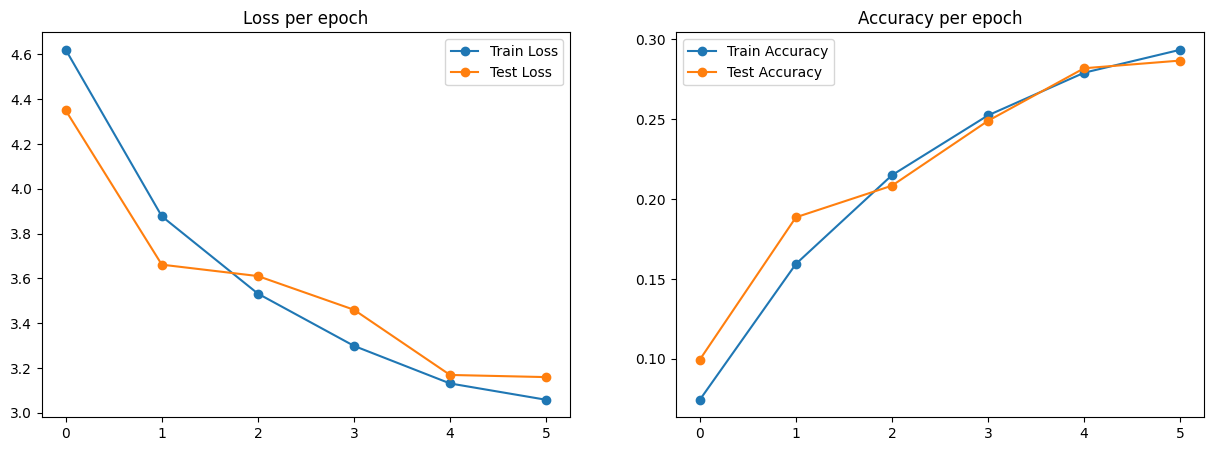

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[21:28:58] Step 20/704: train loss = 2.90029
[21:28:59] Step 40/704: train loss = 2.82459
[21:29:00] Step 60/704: train loss = 2.80848
[21:29:02] Step 80/704: train loss = 2.79489
[21:29:03] Step 100/704: train loss = 2.79779
[21:29:04] Step 120/704: train loss = 2.80363
[21:29:05] Step 140/704: train loss = 2.81185
[21:29:06] Step 160/704: train loss = 2.81397
[21:29:07] Step 180/704: train loss = 2.81991
[21:29:08] Step 200/704: train loss = 2.82595
[21:29:09] Step 220/704: train loss = 2.82989
[21:29:10] Step 240/704: train loss = 2.83436
[21:29:11] Step 260/704: train loss = 2.83717
[21:29:12] Step 280/704: train loss = 2.83535
[21:29:13] Step 300/704: train loss = 2.83535
[21:29:14] Step 320/704: train loss = 2.83887
[21:29:15] Step 340/704: train loss = 2.84495
[21:29:16] Step 360/704: train loss = 2.84828
[21:29:17] Step 380/704: train loss = 2.84876
[21:29:18] Step 400/704: train loss 

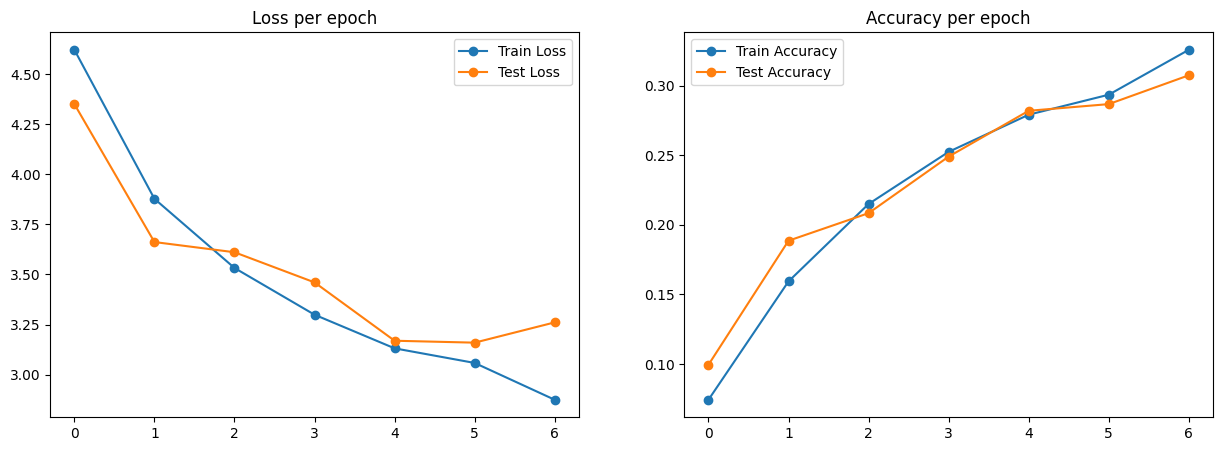

Validation loss didn't improve

 		 ------------------------------ EPOCH: 8 ------------------------------
[21:29:38] Step 20/704: train loss = 2.7366
[21:29:39] Step 40/704: train loss = 2.68324
[21:29:40] Step 60/704: train loss = 2.69675
[21:29:41] Step 80/704: train loss = 2.68177
[21:29:42] Step 100/704: train loss = 2.68711
[21:29:43] Step 120/704: train loss = 2.69631
[21:29:44] Step 140/704: train loss = 2.69812
[21:29:45] Step 160/704: train loss = 2.69784
[21:29:46] Step 180/704: train loss = 2.70381
[21:29:47] Step 200/704: train loss = 2.71405
[21:29:48] Step 220/704: train loss = 2.72841
[21:29:49] Step 240/704: train loss = 2.72948
[21:29:50] Step 260/704: train loss = 2.72681
[21:29:51] Step 280/704: train loss = 2.7244
[21:29:52] Step 300/704: train loss = 2.72138
[21:29:53] Step 320/704: train loss = 2.72312
[21:29:54] Step 340/704: train loss = 2.72444
[21:29:55] Step 360/704: train loss = 2.72557
[21:29:56] Step 380/704: train loss = 2.72925
[21:29:57] Step 400/704: 

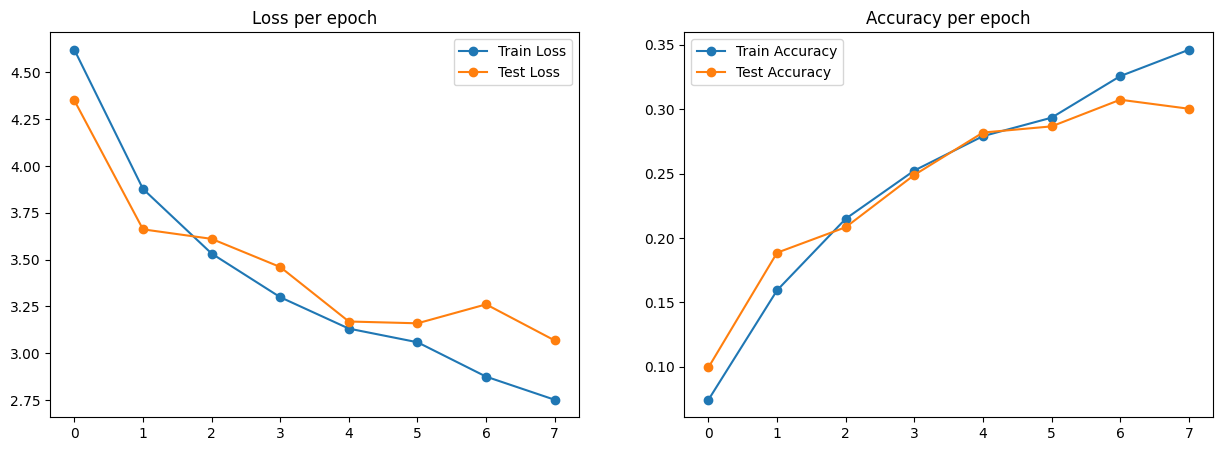

Saving best model

 		 ------------------------------ EPOCH: 9 ------------------------------
[21:30:18] Step 20/704: train loss = 2.53314
[21:30:19] Step 40/704: train loss = 2.48804
[21:30:20] Step 60/704: train loss = 2.50026
[21:30:21] Step 80/704: train loss = 2.51485
[21:30:22] Step 100/704: train loss = 2.50439
[21:30:23] Step 120/704: train loss = 2.51968
[21:30:24] Step 140/704: train loss = 2.52195
[21:30:25] Step 160/704: train loss = 2.52799
[21:30:26] Step 180/704: train loss = 2.53784
[21:30:27] Step 200/704: train loss = 2.54387
[21:30:28] Step 220/704: train loss = 2.55079
[21:30:29] Step 240/704: train loss = 2.56252
[21:30:30] Step 260/704: train loss = 2.57139
[21:30:31] Step 280/704: train loss = 2.57802
[21:30:32] Step 300/704: train loss = 2.58139
[21:30:33] Step 320/704: train loss = 2.58316
[21:30:34] Step 340/704: train loss = 2.58542
[21:30:35] Step 360/704: train loss = 2.588
[21:30:36] Step 380/704: train loss = 2.59343
[21:30:37] Step 400/704: train loss = 

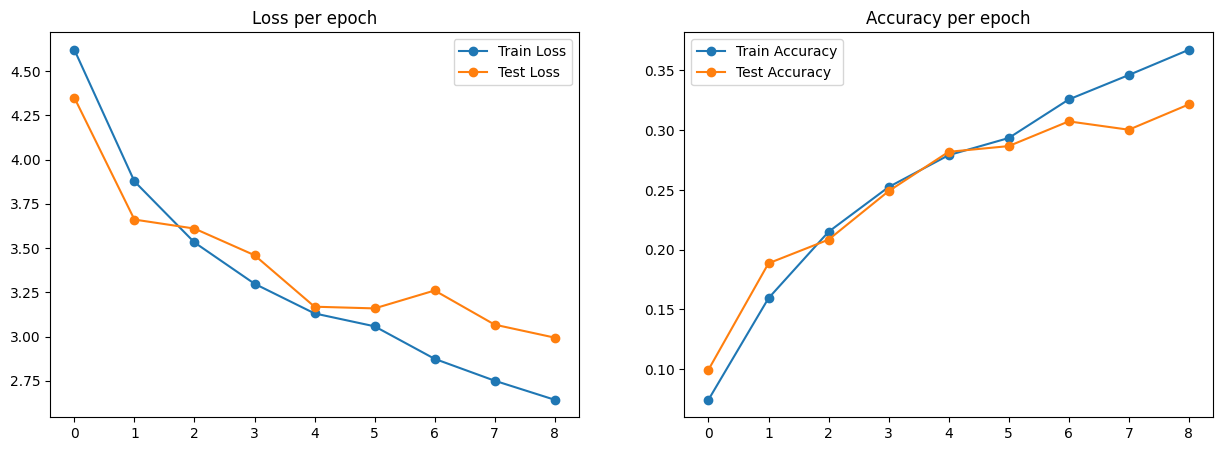

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[21:30:58] Step 20/704: train loss = 2.53637
[21:30:59] Step 40/704: train loss = 2.51882
[21:31:00] Step 60/704: train loss = 2.4882
[21:31:01] Step 80/704: train loss = 2.47273
[21:31:02] Step 100/704: train loss = 2.47597
[21:31:03] Step 120/704: train loss = 2.47445
[21:31:04] Step 140/704: train loss = 2.47678
[21:31:05] Step 160/704: train loss = 2.47878
[21:31:06] Step 180/704: train loss = 2.47567
[21:31:07] Step 200/704: train loss = 2.47462
[21:31:08] Step 220/704: train loss = 2.47262
[21:31:09] Step 240/704: train loss = 2.47809
[21:31:10] Step 260/704: train loss = 2.48359
[21:31:11] Step 280/704: train loss = 2.49459
[21:31:12] Step 300/704: train loss = 2.49446
[21:31:13] Step 320/704: train loss = 2.49702
[21:31:14] Step 340/704: train loss = 2.4959
[21:31:15] Step 360/704: train loss = 2.50216
[21:31:16] Step 380/704: train loss = 2.50747
[21:31:17] Step 400/704: train loss =

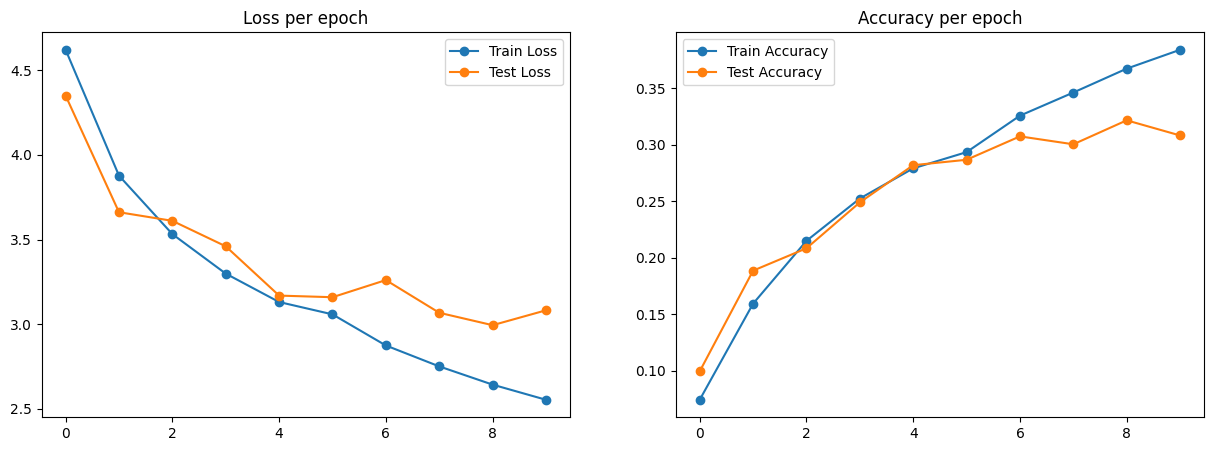

Validation loss didn't improve

 		 ------------------------------ EPOCH: 11 ------------------------------
[21:31:37] Step 20/704: train loss = 2.83776
[21:31:38] Step 40/704: train loss = 2.68483
[21:31:39] Step 60/704: train loss = 2.60832
[21:31:41] Step 80/704: train loss = 2.54521
[21:31:42] Step 100/704: train loss = 2.5083
[21:31:43] Step 120/704: train loss = 2.4872
[21:31:44] Step 140/704: train loss = 2.48076
[21:31:45] Step 160/704: train loss = 2.47217
[21:31:46] Step 180/704: train loss = 2.46911
[21:31:47] Step 200/704: train loss = 2.45617
[21:31:48] Step 220/704: train loss = 2.45431
[21:31:49] Step 240/704: train loss = 2.45203
[21:31:50] Step 260/704: train loss = 2.44979
[21:31:51] Step 280/704: train loss = 2.44989
[21:31:52] Step 300/704: train loss = 2.4535
[21:31:53] Step 320/704: train loss = 2.45761
[21:31:54] Step 340/704: train loss = 2.45908
[21:31:55] Step 360/704: train loss = 2.45828
[21:31:56] Step 380/704: train loss = 2.46137
[21:31:57] Step 400/704: 

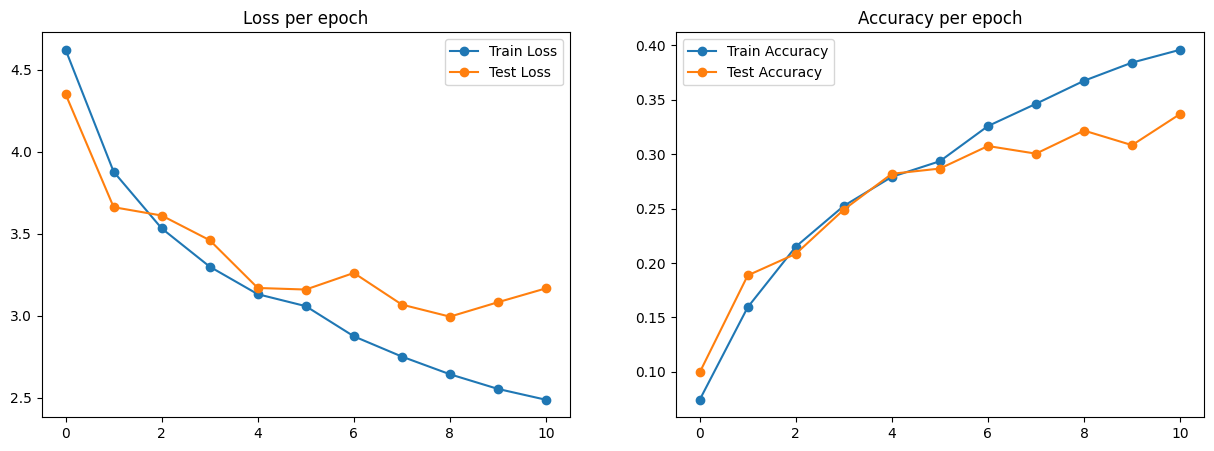

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.99451, last 2 epochs min: 3.08242
Restoring the model at epoch 8: test_accuracy = 0.3216
Model successfully restored

 Training time: 7.0 minutes 16.92 seconds

 Final model is stored to model_epoch_8_test_acc_0.3216.pth


In [92]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [93]:
import pandas as pd

In [94]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [95]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [96]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [97]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[21:32:17] Step 10/79 done
[21:32:17] Step 20/79 done
[21:32:18] Step 30/79 done
[21:32:18] Step 40/79 done
[21:32:19] Step 50/79 done
[21:32:19] Step 60/79 done
[21:32:20] Step 70/79 done


In [98]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,135
2,2,66
3,3,142
4,4,139


In [99]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [100]:
test_predictions_df['class'].value_counts()

class
71     160
137    141
35     134
143    116
87     116
      ... 
30      12
20      10
144      9
153      9
176      7
Name: count, Length: 200, dtype: int64

In [101]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [102]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n01784675
2,val_2.JPEG,n03014705
3,val_3.JPEG,n02808440
4,val_4.JPEG,n03770439


In [103]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)